<a href="https://colab.research.google.com/github/Teknofest-Nane-Limon/tfidf-model-turkish-bullying-/blob/main/tfidf_vectorize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tpot
!pip install scikit-mdr skrebate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.0 MB/s 
     |████████████████████████████████| 192.9 MB 78 kB/s 
     |████████████████████████████████| 139 kB 57.9 MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=b6a32b063b6b26eb81a8ec23861c48eaa28c53b6565286692a6758b3e66f11f7
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for scikit-mdr: filename=scikit_MDR-0.4.4-py3-none-any.whl size=14647 sha256=b2a4277b700fd7cd82071fbf7290ef5418fffa955814a5546c726ec50e3738e0
  Stored in directory: /root/.cache/

In [3]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from tpot import TPOTClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import SGDClassifier 
import sklearn.linear_model
import sklearn.pipeline

from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')



[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
df = pd.read_csv('/content/clean_data 3.csv')
print(df.head(5))

   scraped_id                                               text  \
0           1       -185 altı kendine erkeğim demesin diyen kasa   
1           2  "feminen bir erkek neden olamıyorsun, neden be...   
2           3  "Kızlar böyle tırnağı olmayan da kendine kızım...   
3           4  "Şık olmalı kadın dediğin.Gelisi, gülüşü, bakı...   
4           5  “ Çokta …de “ demek için erkek olmak isterdim....   

                         tagger                 tagged_date          label  \
0  model_tarafından_etiketlendi  2022-07-31 22:11:42.000000  Cinsiyetçilik   
1  model_tarafından_etiketlendi  2022-07-31 22:11:47.000000  Cinsiyetçilik   
2  model_tarafından_etiketlendi  2022-07-31 22:11:49.000000  Cinsiyetçilik   
3  model_tarafından_etiketlendi  2022-07-31 22:11:51.000000  Cinsiyetçilik   
4  model_tarafından_etiketlendi  2022-07-31 22:11:53.000000  Cinsiyetçilik   

                                          clean_data  
0            alti kendine erkegim demesin diyen kasa  
1  feminen b

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3388 entries, 0 to 3387
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   scraped_id   3388 non-null   int64 
 1   text         3388 non-null   object
 2   tagger       3375 non-null   object
 3   tagged_date  3388 non-null   object
 4   label        3388 non-null   object
 5   clean_data   3388 non-null   object
dtypes: int64(1), object(5)
memory usage: 158.9+ KB
None


Modelleme öncesinde hem veriyi küçültmek hemde sadece anlam içeren ifadeleri set içerisinde tutabilmek için durma sözcüklerini corpus içerisinden kaldırdık. Eğitime clean_data yı dahil edeceğimizden text kolonunda bu değişikliği yapmayarak ham veri ile farkını gözle gözlemledik.

In [6]:
nltk.download('stopwords')
stopwordSet = set(stopwords.words('turkish'))
def stop_word(text):
    text = word_tokenize(text, language='turkish')
    text = [word for word in text if not word in stopwordSet]
    text = " ".join(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
df['clean_data'] = df.clean_data.apply(stop_word)

Veri temizlenmeden önce ne kadar duplicate içerik vardı kontrol ettik.

In [8]:
df[df.duplicated(subset='text')].count()

scraped_id     27
text           27
tagger         26
tagged_date    27
label          27
clean_data     27
dtype: int64

Veri temizlendikten sonra daha fazla duplicate veri olabileceğini düşünerek temiz veri üzerinde kontrol ettik.

In [9]:
df[df.duplicated(subset='clean_data')].count()

scraped_id     50
text           50
tagger         49
tagged_date    50
label          50
clean_data     50
dtype: int64

Duplicate olan verileri temizlenen veri içinden eğitim öncesinde kaldırdık bu sayede train ve testte aynı verinin denk gelmesini engelledik ve daha gerçekçi bir sonuç elde ettik. 

In [10]:
df.drop_duplicates(subset='clean_data', inplace=True)

print('Tekrar eden veri sayısı : ')
df[df.duplicated(subset='clean_data')].count()

Tekrar eden veri sayısı : 


scraped_id     0
text           0
tagger         0
tagged_date    0
label          0
clean_data     0
dtype: int64

In [11]:
print(df.head())

   scraped_id                                               text  \
0           1       -185 altı kendine erkeğim demesin diyen kasa   
1           2  "feminen bir erkek neden olamıyorsun, neden be...   
2           3  "Kızlar böyle tırnağı olmayan da kendine kızım...   
3           4  "Şık olmalı kadın dediğin.Gelisi, gülüşü, bakı...   
4           5  “ Çokta …de “ demek için erkek olmak isterdim....   

                         tagger                 tagged_date          label  \
0  model_tarafından_etiketlendi  2022-07-31 22:11:42.000000  Cinsiyetçilik   
1  model_tarafından_etiketlendi  2022-07-31 22:11:47.000000  Cinsiyetçilik   
2  model_tarafından_etiketlendi  2022-07-31 22:11:49.000000  Cinsiyetçilik   
3  model_tarafından_etiketlendi  2022-07-31 22:11:51.000000  Cinsiyetçilik   
4  model_tarafından_etiketlendi  2022-07-31 22:11:53.000000  Cinsiyetçilik   

                                          clean_data  
0            alti kendine erkegim demesin diyen kasa  
1  feminen b

Veri modellemeye hazır hale getirildikten sonra verisetinde geçen her sınıf için sık kullanılan kelimeleri görselleştirerek inceledik.

In [12]:

def generate_wordcloud(words,sentiment):
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("{} Kategorisinde Geçen Favori Kelimeler".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')
    


Kelime Balonu Oluşturuluyor...


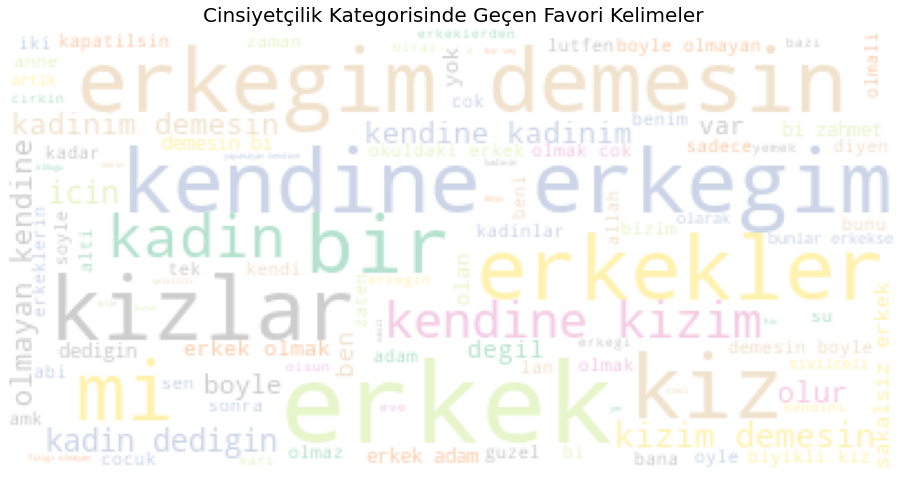

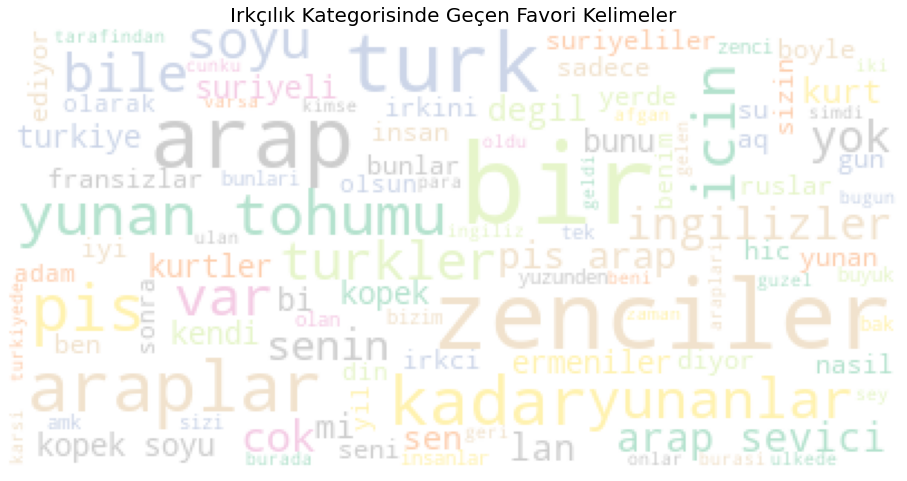

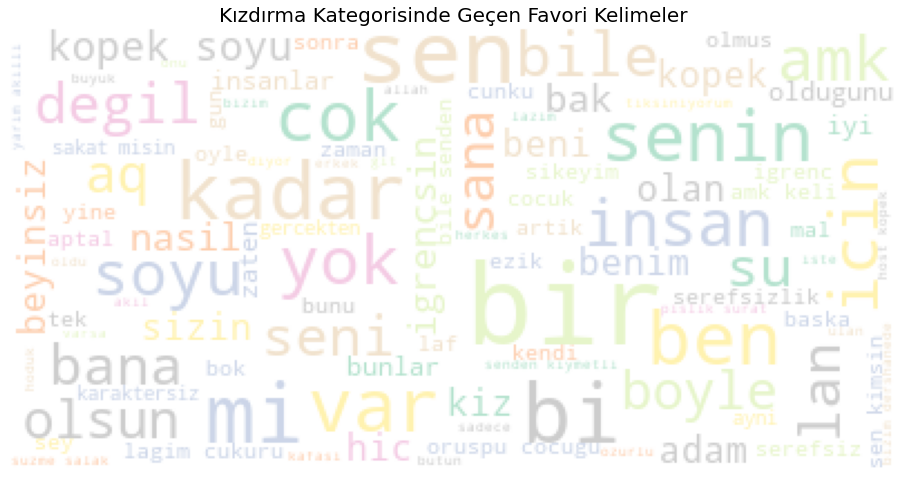

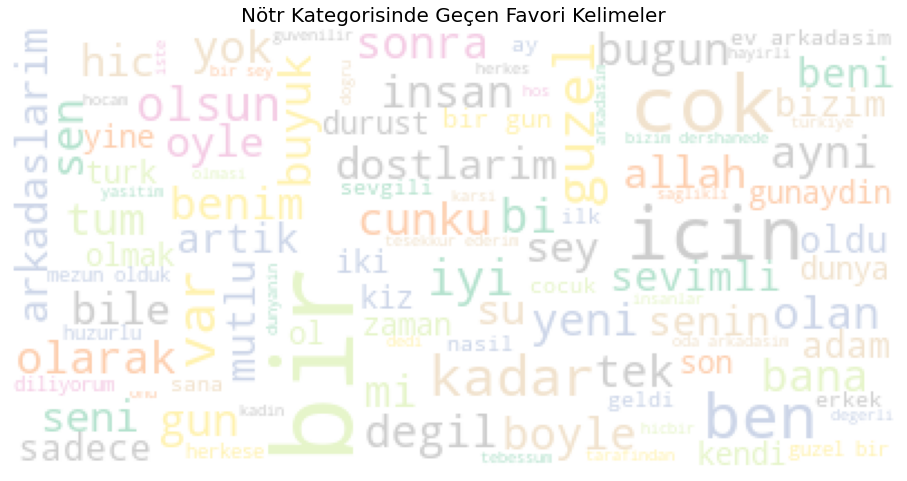

In [13]:
print("Kelime Balonu Oluşturuluyor...")
cinsiyet=" ".join(df[df.label=='Cinsiyetçilik']['clean_data'].values)
irkcilik=" ".join(df[df.label=='Irkçılık']['clean_data'].values)
kizdirma=" ".join(df[df.label=='Kızdırma']['clean_data'].values)
notr=" ".join(df[df.label=='Nötr']['clean_data'].values)

generate_wordcloud(cinsiyet,"Cinsiyetçilik")
generate_wordcloud(irkcilik,"Irkçılık")
generate_wordcloud(kizdirma,"Kızdırma")
generate_wordcloud(notr,"Nötr")


Sık kullanılan kelimelerin sınıflara göre kırılımına baktığımızda modelin recall değerini düşürebilecek metrikleri önceden tahmin edebiliyoruz.

In [14]:
def freq(df_series):
    word_freq= df_series.str.split(expand=True).stack().value_counts()
    word_freq=word_freq.reset_index(name='freq').rename(columns={'index': 'clean_data'})
    top_15_frequent_words = word_freq[:15]
    print(top_15_frequent_words)

Aşağıda yaptığımız sık kullanılan kelimelerin sınıflara göre kırılımı analizi ile Irkçılık ve Kızdırmanın ortak bir çok kelime içerdiğini fark ettik.

In [15]:
label_list= [df[df.label=='Cinsiyetçilik']['clean_data'], 
             df[df.label=='Irkçılık']['clean_data'], 
             df[df.label=='Kızdırma']['clean_data'], 
             df[df.label=='Nötr']['clean_data']]

for i in label_list:
    freq(i)
    print('\n--------------------------\n')


   clean_data  freq
0       erkek   195
1     kendine   153
2     demesin   152
3       kadin    93
4         kiz    72
5         bir    68
6     erkegim    67
7      kizlar    63
8     dedigin    61
9    erkekler    61
10         mi    56
11      boyle    54
12    olmayan    54
13      kizim    52
14      olmak    48

--------------------------

    clean_data  freq
0          bir   117
1         arap   112
2     zenciler    82
3          pis    61
4         turk    61
5        yunan    49
6      araplar    45
7         soyu    44
8       tohumu    42
9        kadar    39
10         var    37
11        icin    34
12       kopek    32
13  ingilizler    32
14    yunanlar    31

--------------------------

   clean_data  freq
0         bir   162
1         sen   101
2          bi    72
3          mi    70
4        soyu    69
5       kadar    65
6       kopek    61
7         var    58
8         amk    57
9         ben    57
10      senin    55
11       icin    54
12       bile    54
13    

Aşağıda veri setinin yüzdelik dağılımını inceledik. Bu sonuç bize model eğitimi bittikten sonra bakmamız gereken tek metriğin accuracy olmadığını göstermiştir. Ayrıca Irkçılık ve Kızdırma verilerinin toplam sayısına göre muhtemelen Irkçılık verileri ile Kızdırma verileri arasında False Negative - False Positive yüksek olacak ve bu da modelin F1-score unu düşürecektir.

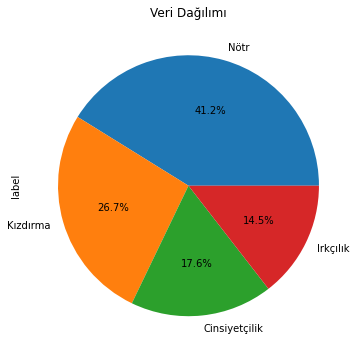

In [16]:
df['label'].value_counts().plot.pie(figsize=(6,6),title="Veri Dağılımı",autopct='%1.1f%%')
plt.gca().set_aspect('equal')

Verileri inceledikten sonra modelleme aşamasına geçiyoruz. Bu aşamada öncelikle target data olan sahanın yani label ın integer bir değere encode edilmesi gerekmektedir. Aşağıda görüldüğü gibi label şuan da object bir değere sahiptir.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3338 entries, 0 to 3387
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   scraped_id   3338 non-null   int64 
 1   text         3338 non-null   object
 2   tagger       3326 non-null   object
 3   tagged_date  3338 non-null   object
 4   label        3338 non-null   object
 5   clean_data   3338 non-null   object
dtypes: int64(1), object(5)
memory usage: 182.5+ KB


In [18]:
df['label'] = LabelEncoder().fit_transform(df['label'])
df.info()

"""
Hangi Sınıfın Nneye Dönüştüğünü Unutmamak İçin Buraya Not Alıyorum...

Cinsiyetçilik - 0
Irkçılık - 1
Kızdırma - 2
Nötr - 3
"""

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3338 entries, 0 to 3387
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   scraped_id   3338 non-null   int64 
 1   text         3338 non-null   object
 2   tagger       3326 non-null   object
 3   tagged_date  3338 non-null   object
 4   label        3338 non-null   int64 
 5   clean_data   3338 non-null   object
dtypes: int64(2), object(4)
memory usage: 182.5+ KB


'\nHangi Sınıfın Nneye Dönüştüğünü Unutmamak İçin Buraya Not Alıyorum...\n\nCinsiyetçilik - 0\nIrkçılık - 1\nKızdırma - 2\nNötr - 3\n'

Temizlediğimiz clean_data alanının ise matematiksel bir anlam içermesi gerekir ki modellenebilsin. Bu yüzden TfidfVectorizer kullanacağız.

In [19]:

def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [20]:
tfidf_vect = TfidfVectorizer()
tfidf_vect_fit=tfidf_vect.fit(df['clean_data'])

Eğitim verilerini yeniden isimlendiriyoruz..

In [21]:
X_train=vectorize(df['clean_data'],tfidf_vect_fit)
y_train=df['label']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TPOTClassifier yöntemi elimizdeki veri setinden örnek populasyon alıp belli bir generation a kadar bakarak max verim alacağımız modeli ve modelin best parametrelerini tespit etmemizi sağlayan bir genetik algoritma yöntemidir. Buradan alacağımız çıktıya göre ML modelimizi kuracağız. Bunu yaparken cross validation yönteminden yararlanacağız. Veri setimiz dağınık olduğundan dolayı KFold değil StratifiedKFold kullanacağız.

In [ ]:
"""
print(X_train.shape, y_train.shape)
# (3338, 17668) (3338,)

cv = StratifiedKFold(n_splits=4)

model = TPOTClassifier(generations=3, population_size=40, cv=cv, scoring='accuracy', verbosity=2)

model.fit(X_train, y_train)
# best model
model.export('tpot_data.py')"""

Çıkan optimum değerler:

----


Doğruluğunu bu parametrelerle modeli oluşturarak test edeceğiz:

İyi sonuç alabileceğimiz modelleri literatur de araştırarak tespit ettik ve öncelikle default değerleri ile denedik ardından hyper parameters tuning yöntemi ile en iyi parametrelere ulaşıp modelimizi bu parametreler ile eğittik. Bir çok sınıflandırıcı deneyeceğimiz için **print_results()** fonksiyonu yazdık.

In [22]:
def print_results(results):
    
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))


In [ ]:
rf = BaggingClassifier(random_state=42)
scores = cross_val_score(rf,X_train,y_train,cv=10)
print(scores)
print(scores.mean())

"""
[0.73652695 0.82634731 0.83233533 0.85329341 0.79341317 0.74251497
 0.69760479 0.55988024 0.74174174 0.58858859]
0.7372246497995001
"""



```
[0.73652695 0.82634731 0.83233533 0.85329341 0.79341317 0.74251497
 0.69760479 0.55988024 0.74174174 0.58858859]
0.7372246497995001
```



In [ ]:
clf = BaggingClassifier(random_state=42)
parameters = {
    'max_samples': [0.05, 0.1, 0.2, 0.5], # for bootstrap sampling
    'max_features': [0.3,0.5,0.7,0.9]} 
cv = GridSearchCV(clf,parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)
print(cv.best_estimator_)

"""

BEST PARAMS: {'max_features': 0.7, 'max_samples': 0.5}

0.591 (+/-0.1) for {'max_features': 0.3, 'max_samples': 0.05}
0.625 (+/-0.099) for {'max_features': 0.3, 'max_samples': 0.1}
0.655 (+/-0.094) for {'max_features': 0.3, 'max_samples': 0.2}
0.692 (+/-0.1) for {'max_features': 0.3, 'max_samples': 0.5}
0.617 (+/-0.118) for {'max_features': 0.5, 'max_samples': 0.05}
0.671 (+/-0.111) for {'max_features': 0.5, 'max_samples': 0.1}
0.684 (+/-0.145) for {'max_features': 0.5, 'max_samples': 0.2}
0.723 (+/-0.115) for {'max_features': 0.5, 'max_samples': 0.5}
0.578 (+/-0.12) for {'max_features': 0.7, 'max_samples': 0.05}
0.658 (+/-0.125) for {'max_features': 0.7, 'max_samples': 0.1}
0.694 (+/-0.131) for {'max_features': 0.7, 'max_samples': 0.2}
0.726 (+/-0.152) for {'max_features': 0.7, 'max_samples': 0.5}
0.591 (+/-0.105) for {'max_features': 0.9, 'max_samples': 0.05}
0.65 (+/-0.103) for {'max_features': 0.9, 'max_samples': 0.1}
0.686 (+/-0.13) for {'max_features': 0.9, 'max_samples': 0.2}
0.723 (+/-0.133) for {'max_features': 0.9, 'max_samples': 0.5}
BaggingClassifier(max_features=0.7, max_samples=0.5, random_state=42)

"""



```
BEST PARAMS: {'max_features': 0.7, 'max_samples': 0.5}

0.591 (+/-0.1) for {'max_features': 0.3, 'max_samples': 0.05}
0.625 (+/-0.099) for {'max_features': 0.3, 'max_samples': 0.1}
0.655 (+/-0.094) for {'max_features': 0.3, 'max_samples': 0.2}
0.692 (+/-0.1) for {'max_features': 0.3, 'max_samples': 0.5}
0.617 (+/-0.118) for {'max_features': 0.5, 'max_samples': 0.05}
0.671 (+/-0.111) for {'max_features': 0.5, 'max_samples': 0.1}
0.684 (+/-0.145) for {'max_features': 0.5, 'max_samples': 0.2}
0.723 (+/-0.115) for {'max_features': 0.5, 'max_samples': 0.5}
0.578 (+/-0.12) for {'max_features': 0.7, 'max_samples': 0.05}
0.658 (+/-0.125) for {'max_features': 0.7, 'max_samples': 0.1}
0.694 (+/-0.131) for {'max_features': 0.7, 'max_samples': 0.2}
0.726 (+/-0.152) for {'max_features': 0.7, 'max_samples': 0.5}
0.591 (+/-0.105) for {'max_features': 0.9, 'max_samples': 0.05}
0.65 (+/-0.103) for {'max_features': 0.9, 'max_samples': 0.1}
0.686 (+/-0.13) for {'max_features': 0.9, 'max_samples': 0.2}
0.723 (+/-0.133) for {'max_features': 0.9, 'max_samples': 0.5}
BaggingClassifier(max_features=0.7, max_samples=0.5, random_state=42)
```



In [ ]:
bst = xgb.XGBClassifier(random_state=42)
scores = cross_val_score(bst,X_train,y_train,cv=10)
print(scores)
print(scores.mean())

"""
[0.75748503 0.83233533 0.85928144 0.83832335 0.82335329 0.77844311
 0.73053892 0.61976048 0.76576577 0.61561562]
0.7620902339465212
"""



```
[0.75748503 0.83233533 0.85928144 0.83832335 0.82335329 0.77844311
 0.73053892 0.61976048 0.76576577 0.61561562]
0.7620902339465212
```



In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
clf = xgb.XGBClassifier(random_state=42)
parameters={'max_depth': [3, 18, 1],
        'gamma': [1, 9],
        'reg_alpha' : [40, 180, 1],
        'reg_lambda' : [0,1],
        'colsample_bytree' : [0.5, 1],
        'min_child_weight' : [0, 10, 1]
    }

cv = GridSearchCV(clf,parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)
print(cv.best_estimator_)

In [ ]:
rf = RandomForestClassifier(random_state=42)
scores = cross_val_score(rf,X_train,y_train,cv=10)
print(scores)
print(scores.mean())
"""
[0.76946108 0.7754491  0.81137725 0.85329341 0.79341317 0.74850299
 0.69161677 0.59281437 0.77177177 0.59459459]
0.7402294510078942
"""



```
[0.76946108 0.7754491  0.81137725 0.85329341 0.79341317 0.74850299
 0.69161677 0.59281437 0.77177177 0.59459459]
0.7402294510078942
```



In [ ]:
rf = RandomForestClassifier(random_state=42)
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None],
    'bootstrap': [True, False],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)
print(cv.best_estimator_)




```
BEST PARAMS: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

0.413 (+/-0.004) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.413 (+/-0.004) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.413 (+/-0.004) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.413 (+/-0.003) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.413 (+/-0.003) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.413 (+/-0.003) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.414 (+/-0.004) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
0.414 (+/-0.004) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
0.414 (+/-0.004) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
0.483 (+/-0.09) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
0.463 (+/-0.079) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.455 (+/-0.081) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.484 (+/-0.088) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
0.463 (+/-0.08) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.455 (+/-0.081) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.482 (+/-0.084) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 5}
0.463 (+/-0.078) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.456 (+/-0.082) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.479 (+/-0.082) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5}
0.463 (+/-0.081) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
0.454 (+/-0.082) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.479 (+/-0.082) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5}
0.463 (+/-0.081) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.454 (+/-0.082) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.479 (+/-0.082) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 5}
0.463 (+/-0.081) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.454 (+/-0.082) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.484 (+/-0.082) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 5}
0.463 (+/-0.076) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
0.453 (+/-0.078) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
0.484 (+/-0.082) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 5}
0.463 (+/-0.076) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
0.453 (+/-0.078) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
0.485 (+/-0.082) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 5}
0.463 (+/-0.076) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
0.453 (+/-0.078) for {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
0.522 (+/-0.086) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
0.532 (+/-0.111) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.535 (+/-0.142) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.514 (+/-0.088) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
0.531 (+/-0.111) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.534 (+/-0.138) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.512 (+/-0.089) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 5}
0.532 (+/-0.107) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.536 (+/-0.136) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.51 (+/-0.091) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5}
0.525 (+/-0.109) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
0.526 (+/-0.126) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.51 (+/-0.091) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5}
0.525 (+/-0.11) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.527 (+/-0.127) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.511 (+/-0.089) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 5}
0.525 (+/-0.106) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.526 (+/-0.124) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.519 (+/-0.077) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 5}
0.532 (+/-0.114) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
0.533 (+/-0.134) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
0.519 (+/-0.077) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 5}
0.532 (+/-0.114) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
0.533 (+/-0.134) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
0.519 (+/-0.077) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 5}
0.532 (+/-0.114) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
0.532 (+/-0.133) for {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
0.687 (+/-0.124) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
0.728 (+/-0.138) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.726 (+/-0.143) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.702 (+/-0.147) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
0.728 (+/-0.139) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.736 (+/-0.137) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.707 (+/-0.146) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 5}
0.726 (+/-0.137) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.736 (+/-0.134) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.688 (+/-0.123) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5}
0.737 (+/-0.125) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
0.742 (+/-0.132) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.687 (+/-0.122) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5}
0.738 (+/-0.128) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.744 (+/-0.129) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.692 (+/-0.118) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 5}
0.739 (+/-0.121) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.742 (+/-0.131) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.64 (+/-0.123) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 5}
0.674 (+/-0.102) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
0.678 (+/-0.124) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
0.64 (+/-0.123) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 5}
0.674 (+/-0.102) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
0.678 (+/-0.124) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
0.64 (+/-0.124) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 5}
0.675 (+/-0.101) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
0.678 (+/-0.123) for {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
0.421 (+/-0.017) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.421 (+/-0.017) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.421 (+/-0.017) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.421 (+/-0.017) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.421 (+/-0.017) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.421 (+/-0.017) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.421 (+/-0.017) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
0.421 (+/-0.017) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
0.421 (+/-0.017) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 5}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
0.412 (+/-0.001) for {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
0.482 (+/-0.063) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
0.46 (+/-0.072) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.453 (+/-0.066) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.48 (+/-0.054) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
0.46 (+/-0.072) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.452 (+/-0.066) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.483 (+/-0.053) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 5}
0.46 (+/-0.071) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.452 (+/-0.063) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.479 (+/-0.054) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5}
0.459 (+/-0.069) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
0.451 (+/-0.06) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.479 (+/-0.054) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5}
0.459 (+/-0.068) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.451 (+/-0.06) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.479 (+/-0.053) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 5}
0.458 (+/-0.067) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.451 (+/-0.06) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.476 (+/-0.061) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 5}
0.46 (+/-0.066) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
0.45 (+/-0.06) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
0.476 (+/-0.061) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 5}
0.46 (+/-0.066) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
0.45 (+/-0.06) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
0.476 (+/-0.061) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 5}
0.46 (+/-0.067) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
0.45 (+/-0.06) for {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
0.541 (+/-0.073) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
0.539 (+/-0.089) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.538 (+/-0.095) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.548 (+/-0.075) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
0.533 (+/-0.09) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.535 (+/-0.09) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.551 (+/-0.089) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 5}
0.539 (+/-0.087) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.534 (+/-0.089) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.544 (+/-0.073) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5}
0.528 (+/-0.081) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
0.526 (+/-0.079) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.544 (+/-0.073) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5}
0.527 (+/-0.082) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.526 (+/-0.077) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.546 (+/-0.076) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 5}
0.528 (+/-0.081) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.528 (+/-0.079) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.551 (+/-0.093) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 5}
0.521 (+/-0.079) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
0.524 (+/-0.087) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
0.551 (+/-0.093) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 5}
0.521 (+/-0.079) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
0.524 (+/-0.087) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
0.552 (+/-0.093) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 5}
0.522 (+/-0.079) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
0.525 (+/-0.086) for {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
0.705 (+/-0.133) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
0.747 (+/-0.137) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.743 (+/-0.128) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.723 (+/-0.143) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
0.752 (+/-0.144) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.755 (+/-0.145) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.722 (+/-0.137) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 5}
0.755 (+/-0.152) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.757 (+/-0.147) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.715 (+/-0.141) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5}
0.76 (+/-0.153) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
0.754 (+/-0.153) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.713 (+/-0.135) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5}
0.759 (+/-0.152) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.753 (+/-0.155) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.72 (+/-0.133) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 5}
0.759 (+/-0.154) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.756 (+/-0.153) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.696 (+/-0.117) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 5}
0.735 (+/-0.142) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
0.735 (+/-0.137) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
0.696 (+/-0.117) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 5}
0.735 (+/-0.142) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
0.735 (+/-0.137) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
0.694 (+/-0.116) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 5}
0.736 (+/-0.14) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
0.736 (+/-0.136) for {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
RandomForestClassifier(bootstrap=False, min_samples_leaf=2, n_estimators=50,
                       random_state=42)
```



In [ ]:
clf = lgb.LGBMClassifier(random_state=42)
scores = cross_val_score(clf,X_train,y_train,cv=10)
print(scores)
print(scores.mean())
"""
[0.67365269 0.7754491  0.72155689 0.78742515 0.73053892 0.67964072
 0.63473054 0.55688623 0.70570571 0.56156156]
0.6827147506788225
"""



```
[0.67365269 0.7754491  0.72155689 0.78742515 0.73053892 0.67964072
 0.63473054 0.55688623 0.70570571 0.56156156]
0.6827147506788225
```



In [ ]:
clf = lgb.LGBMClassifier(random_state=42)
parameters = {
        'max_depth': [10, 13],
        'min_data_in_leaf': [90, 120],
        'num_leaves': [1200, 1550]
}
cv = GridSearchCV(clf,parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)
print(cv.best_estimator_)

"""
BEST PARAMS: {'max_depth': 10, 'min_data_in_leaf': 90, 'num_leaves': 1200}

0.504 (+/-0.064) for {'max_depth': 10, 'min_data_in_leaf': 90, 'num_leaves': 1200}
0.504 (+/-0.064) for {'max_depth': 10, 'min_data_in_leaf': 90, 'num_leaves': 1550}
0.495 (+/-0.077) for {'max_depth': 10, 'min_data_in_leaf': 120, 'num_leaves': 1200}
0.495 (+/-0.077) for {'max_depth': 10, 'min_data_in_leaf': 120, 'num_leaves': 1550}
0.503 (+/-0.063) for {'max_depth': 13, 'min_data_in_leaf': 90, 'num_leaves': 1200}
0.503 (+/-0.063) for {'max_depth': 13, 'min_data_in_leaf': 90, 'num_leaves': 1550}
0.495 (+/-0.077) for {'max_depth': 13, 'min_data_in_leaf': 120, 'num_leaves': 1200}
0.495 (+/-0.077) for {'max_depth': 13, 'min_data_in_leaf': 120, 'num_leaves': 1550}
LGBMClassifier(max_depth=10, min_data_in_leaf=90, num_leaves=1200,
               random_state=42)
"""



```
BEST PARAMS: {'max_depth': 10, 'min_data_in_leaf': 90, 'num_leaves': 1200}

0.504 (+/-0.064) for {'max_depth': 10, 'min_data_in_leaf': 90, 'num_leaves': 1200}
0.504 (+/-0.064) for {'max_depth': 10, 'min_data_in_leaf': 90, 'num_leaves': 1550}
0.495 (+/-0.077) for {'max_depth': 10, 'min_data_in_leaf': 120, 'num_leaves': 1200}
0.495 (+/-0.077) for {'max_depth': 10, 'min_data_in_leaf': 120, 'num_leaves': 1550}
0.503 (+/-0.063) for {'max_depth': 13, 'min_data_in_leaf': 90, 'num_leaves': 1200}
0.503 (+/-0.063) for {'max_depth': 13, 'min_data_in_leaf': 90, 'num_leaves': 1550}
0.495 (+/-0.077) for {'max_depth': 13, 'min_data_in_leaf': 120, 'num_leaves': 1200}
0.495 (+/-0.077) for {'max_depth': 13, 'min_data_in_leaf': 120, 'num_leaves': 1550}
LGBMClassifier(max_depth=10, min_data_in_leaf=90, num_leaves=1200,
               random_state=42)
```



In [ ]:
clf = sklearn.linear_model.SGDClassifier(random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv = 10)
print(scores)
print(scores.mean())
"""
[0.79041916 0.85628743 0.84431138 0.87125749 0.81736527 0.79341317
 0.73053892 0.62874251 0.76576577 0.63363363]
0.7731734728740717
"""



```
[0.79041916 0.85628743 0.84431138 0.87125749 0.81736527 0.79341317
 0.73053892 0.62874251 0.76576577 0.63363363]
0.7731734728740717
```



In [ ]:
clf = sklearn.linear_model.SGDClassifier(random_state=42)
parameters = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}
cv = GridSearchCV(clf,parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)
print(cv.best_estimator_)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

Denediğimiz bütün yöntemlerden çıkardığımız sonuçlara göre en iyi sonuçları xgboots ve SGDClassifier algoritmalarından alıyorduk. Bu nedenle xgboots ve SGDClassifier yöntemlerinin hyper parametrelerini vererek modeli daha ne kadar iyileştirebileceğimizi kontrol edeceğiz.

## Hyper Parametre ile Denemeler

In [ ]:
clf = lgb.LGBMClassifier(random_state=42, max_depth = None, )
scores = cross_val_score(clf,X_train,y_train,cv=10)
print(scores)
print(scores.mean())

In [ ]:
rf = RandomForestClassifier(random_state=42, bootstrap= False, max_depth = None, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 50)
scores = cross_val_score(rf,X_train,y_train,cv=10)
print(scores)
print(scores.mean())



```
[0.74850299 0.81137725 0.83532934 0.86826347 0.82335329 0.78443114
 0.70658683 0.60778443 0.81081081 0.59459459]
0.7591034147920375
```

